In [5]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.model_selection import GridSearchCV
from shapely.ops import cascaded_union, polygonize
import math
import shapely.geometry as geometry
from scipy.spatial import Delaunay

# Open csv data

In [3]:
df = pd.read_csv('argo_noise.csv')

In [4]:
df

,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0
0,28.271656,26.475980,24.774204,28.890116,26.933702,27.588029,26.815596,25.174956,28.368548,24.993509,...,18.778396,19.471599,20.817124,23.745616,18.633782,23.172912,21.028164,21.688388,22.341419,22.377907
1,24.630653,22.206214,27.145454,23.069812,28.100137,22.735192,23.333704,23.605529,24.309554,20.211763,...,26.161605,21.850249,23.355129,23.732845,24.325297,21.061650,24.801436,19.635627,22.739268,22.688188
2,26.645738,27.559360,25.427561,29.353835,28.281940,25.294827,27.594989,27.013135,24.573419,27.425873,...,25.641102,22.296257,22.875693,26.743430,26.034464,25.583470,25.612185,22.156584,23.430322,24.186024
3,20.081958,21.818964,24.648526,21.538740,20.932183,18.102642,19.563537,21.432089,18.892251,23.547599,...,22.088190,18.356420,20.740268,17.491619,16.699943,22.110393,16.904356,19.865791,20.471737,18.128048
4,27.393744,27.746599,25.702441,24.969792,27.884811,28.763701,23.809709,24.494690,26.192096,27.646421,...,22.740234,25.219407,24.200999,24.550022,24.278778,23.704876,21.734315,25.868222,25.059922,23.422749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7125,10.667541,7.999964,7.859529,11.927433,7.665661,8.309333,13.797982,9.434087,8.442610,15.706676,...,12.118345,7.226565,10.273212,8.745048,8.220488,9.265417,10.711252,9.631361,9.642308,9.174150
7126,11.328040,12.801410,12.655432,4.929943,8.035285,12.555923,9.250522,10.777103,9.861570,9.543888,...,11.833507,6.932466,9.622373,11.617892,11.706171,12.518695,8.694928,6.724504,10.438752,9.489188
7127,8.072770,9.118884,8.883305,10.120174,9.593995,8.238091,10.110977,10.380536,10.232491,13.601296,...,11.675589,9.097667,13.014943,8.024189,6.282848,7.814262,8.531503,5.226962,11.427456,8.750951
7128,5.380665,7.779945,8.846936,6.081216,10.357850,11.109682,5.297861,11.458248,10.758820,9.581308,...,9.380196,11.077471,9.832296,7.445221,4.643903,8.592179,8.512248,6.039928,7.904116,10.168116


# Define data for the model

In [ ]:
pres = df.columns[2:].values

In [ ]:
lon = df.iloc[:,0].values
lat = df.iloc[:,1].values

In [ ]:
X = df.iloc[:,2:].values

In [ ]:
X.shape

# Scale data

In [ ]:
Xscaled = preprocessing.scale(X)

# First model analysis

In [ ]:
pca = PCA()

In [ ]:
pca.fit(Xscaled)

In [ ]:
Xpca = pca.transform(Xscaled)

In [ ]:
pca.components_.shape

## Verify pca components

In [ ]:
X_proj = pd.DataFrame(Xpca, columns=[f'PC{i}' for i in range(1, pca.components_.shape[0]+1)])
X_proj

In [ ]:
sns.heatmap(X_proj.corr(), cmap='coolwarm')

In [ ]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial space)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(Xscaled[:,0], Xscaled[:,1])

plt.subplot(1,2,2)
plt.title('PC1 vs PC2 (new space)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1]);

In [ ]:
# Computational proof
W = pca.components_.T
print("Shape of W: ", W.shape)
print("Shape of X", Xscaled.shape)

In [ ]:
pca.explained_variance_ratio_.cumsum()[0:10]

In [ ]:
plt.plot(pca.explained_variance_ratio_[0:6])
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

We can see that with only a few PCA components we can explain 99.9% of the covariance of the data

In [ ]:
pca = PCA(n_components=6)
pca.fit(Xscaled)
Xpca = pca.transform(Xscaled)

In [ ]:
Xpca

# Train the unsupervised ML model

## Loss function

In [ ]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

## Train the model with grid search to define the best params with the best score

In [ ]:
# Instantiate model
model = mixture.GaussianMixture()

param_grid = {
    "n_components": range(2, 12),
    "covariance_type": ["full"],
#     "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    model, param_grid=param_grid, scoring=gmm_bic_score, verbose=2
)
grid_search.fit(Xpca)

In [ ]:
comp_df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
comp_df["mean_test_score"] = -comp_df["mean_test_score"]
comp_df = comp_df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
comp_df.sort_values(by="BIC score").head()

We can see that the best model is with 6 components

In [ ]:
sns.catplot(
    data=comp_df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

## Prepare the data for data plotting

In [ ]:
labels = grid_search.predict(Xpca)

In [ ]:
# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = grid_search.predict_proba(Xpca)

In [ ]:
# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

In [ ]:
df.shape

In [ ]:
# put the labels and maximum posterior probabilities back in original dataframe
df.insert(2,'label',labels,True)
df.insert(3,'max posterior prob',max_posterior_probs,True) 
df

In [ ]:
# group profiles according to label
grouped_unsorted = df.groupby('label')

In [ ]:
# calculate mean of all profiles in each class
df_means = grouped_unsorted.mean()

In [ ]:
n_comp = grid_search.best_estimator_.n_components

In [ ]:
# extrat sea surface temperatures (SSTs)
T15_means = df_means['15.0'].values

# sort mean temperatuer at 15 dbar from coldest to warmest
old2new = np.argsort(T15_means)

# create dictionary object for sorting
di = dict(zip(old2new,range(0,n_comp)))

# add new column to dataframe - sorted label
df.insert(3,'label_sorted',df['label'].map(di))

In [ ]:
# group profiles according to label
grouped = df.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means = grouped.mean()

# calculate stdevs of all profiles in each class
dfg_stds = grouped.std()

# number or profiles in each class
nprofs = grouped['x'].count().values

In [ ]:
print(dfg_means['15.0'])

In [ ]:
p = np.asarray([float(i) for i in pres])

In [ ]:
# initialize the figure
plt.figure(figsize=(35, 42))
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = cm.coolwarm(np.linspace(0,1,n_comp))

# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    
    # extract means
    mean_lon = dfg_means.iloc[nrow,0]
    mean_lat = dfg_means.iloc[nrow,1]
    mean_maxpp = dfg_means.iloc[nrow,3]
    mean_T = dfg_means.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon = dfg_stds.iloc[nrow,0]
    std_lat = dfg_stds.iloc[nrow,1]
    std_maxpp = dfg_stds.iloc[nrow,3]
    std_T = dfg_stds.iloc[nrow,4:].values
    
    # select subplot
    plt.subplot(int(np.ceil(n_comp/5)),5,num)
    plt.plot(mean_T, p, marker='', linestyle='solid', color=palette[nrow], linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, p, marker='', linestyle='dashed', color=palette[nrow], linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, p, marker='', linestyle='dashed', color=palette[nrow], linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([0,1000])
    ax = plt.gca()
    ax.invert_yaxis() 
    plt.xlim([-2, 20])
    ax.grid(True)
    
    fs = 16 # font size
    plt.xlabel('Temperature (°C)', fontsize=fs)
    plt.ylabel('Pressure (dbar)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # text box
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs[nrow], ),
        r'Mean lon = %i' % (mean_lon, ),
        r'Mean lat = %i' % (mean_lat, ),
        r'Post. = %.2f' % (mean_maxpp, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)
    
plt.show()
    

# Create the polygons for data QC

## Convex hull

In [ ]:
points = []
for i, value in enumerate(mean_T):
    points.append([value-std_T[i], float(pres[i])])
    points.append([value+std_T[i], float(pres[i])])
points = np.array(points)

In [ ]:
hull = ConvexHull(points)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

We can see that convex hull is not the best way to define the polygon

## Concave hull

In [ ]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                numbers don't fall inward as much as larger numbers. Too large,
                and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        if area == 0:
            area = 1.000000000154332e-09
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))

    return cascaded_union(triangles), edge_points

In [ ]:

points = []
for i, value in enumerate(mean_T):
    points.append((value-std_T[i], float(pres[i])))
    points.append((value+std_T[i], float(pres[i])))
points_point = [geometry.Point(xy) for xy in points]

In [ ]:
concave_hull, edge_points = alpha_shape(points_point, alpha=0.1)

In [ ]:
def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig

In [ ]:
points = []
x = []
y = []
for i, value in enumerate(mean_T):
    x.append(value-std_T[i])
    x.append(value+std_T[i])
    y.append(float(pres[i]))
    y.append(float(pres[i]))

In [ ]:
plt.plot(*concave_hull.exterior.xy)
plt.plot(x,y,'o', color='#f16824')

In [2]:
import pandas as pd

In [6]:
# Create IOOS Flags

from ioos_qc import qartod

argo_noise = pd.read_csv('argo_noise.csv')

spike_flags = pd.DataFrame(index=argo_noise.index,columns=argo_noise.columns)
range_flags = pd.DataFrame(index=argo_noise.index,columns=argo_noise.columns)

for index in argo_noise.index:
   flags = qartod.spike_test(inp=argo_noise.iloc[index],suspect_threshold=3.0,fail_threshold=8.0)
   spike_flags.iloc[index] = flags
   flags = qartod.gross_range_test(inp=argo_noise.iloc[index],fail_span=[0,30])
   range_flags.iloc[index] = flags 

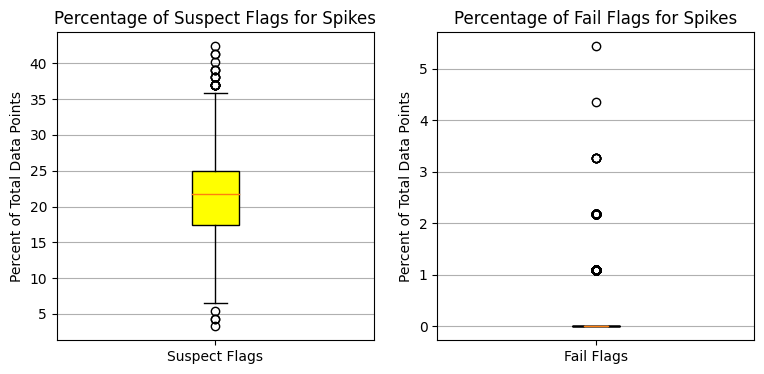

In [7]:
#spike_flags = pd.read_csv('spike_flags.csv')

spike_suspect_per = spike_flags.apply(lambda x:x[x==3].count()/x.count()*100,axis=1)
spike_fail_per = spike_flags.apply(lambda x:x[x==4].count()/x.count()*100,axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

bplot1 = ax1.boxplot([spike_suspect_per],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['Suspect Flags'])  # will be used to label x-ticks

bplot2 = ax2.boxplot([spike_fail_per],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['Fail Flags'])  # will be used to label x-ticks 

ax1.set_title('Percentage of Suspect Flags for Spikes')
ax2.set_title('Percentage of Fail Flags for Spikes')

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Percent of Total Data Points')

colors = ['#FFFF00','#FFA500']

for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


plt.show()

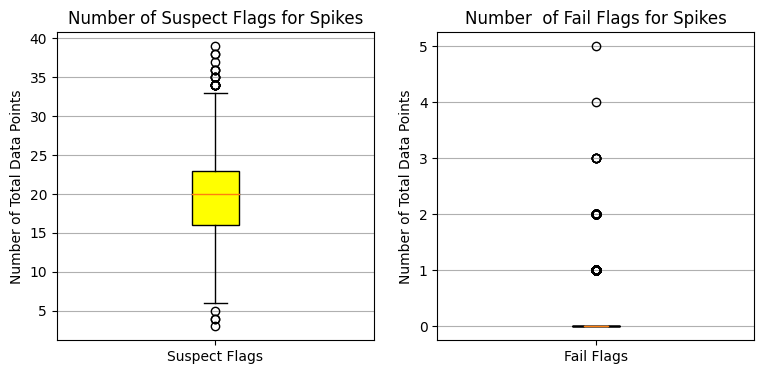

In [8]:
#spike_flags = pd.read_csv('spike_flags.csv')

spike_suspect_count = spike_flags.apply(lambda x:x[x==3].count(),axis=1)
spike_fail_count = spike_flags.apply(lambda x:x[x==4].count(),axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

bplot1 = ax1.boxplot([spike_suspect_count],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['Suspect Flags'])  # will be used to label x-ticks

bplot2 = ax2.boxplot([spike_fail_count],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['Fail Flags'])  # will be used to label x-ticks 

ax1.set_title('Number of Suspect Flags for Spikes')
ax2.set_title('Number  of Fail Flags for Spikes')

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Number of Total Data Points')

colors = ['#FFFF00','#FFA500']

for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


plt.show()